# Crypto Currency Predicitons
Team members:

* Julio Oliveira
* Manish Ranjan
* Rachana Sooraj 

In [89]:
import numpy as np
import pandas as pd


from fitter import Fitter
from pygam import LinearGAM, GammaGAM, LogisticGAM
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor

import seaborn as sns
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter

import plotly.io as pio

pio.renderers

Renderers configuration
-----------------------
    Default renderer: 'plotly_mimetype+notebook'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [2]:
coins = ['bitcoin', 'ethereum', 'cardano']

We first load the 3 datasets for each of the coins

In [3]:
bitcoin = pd.read_csv('../data/external/bitcoin.csv', parse_dates=['Date'])
cardano = pd.read_csv('../data/external/cardano.csv', parse_dates=['Date'])
ethereum = pd.read_csv('../data/external/ethereum.csv', parse_dates=['Date'])

df = pd.concat([bitcoin, cardano, ethereum], axis=0)

In [4]:
df.shape

(6525, 10)

In [5]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


Total or records for each coin.

In [6]:
df.value_counts(['Symbol'])

Symbol
BTC       2991
ETH       2160
ADA       1374
dtype: int64

In [7]:
df.dtypes

SNo                   int64
Name                 object
Symbol               object
Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Marketcap           float64
dtype: object

## Data Exploration

Now lets look into some metrics for each of the coins

### Bitcoin

In [8]:
print(
    f"Min Date: {df[df.Symbol == 'BTC'].Date.min()}, Max Date: {df[df.Symbol == 'BTC'].Date.max()}"
)


Min Date: 2013-04-29 23:59:59, Max Date: 2021-07-06 23:59:59


In [9]:
df[df.Symbol == 'BTC'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2991.000000,2991.000000,2991.000000,2991.000000,2991.000000,2.991000e+03,2.991000e+03
mean,1496.000000,6893.326038,6486.009539,6700.146240,6711.290443,1.090633e+10,1.208761e+11
std,863.571653,11642.832456,10869.032130,11288.043736,11298.141921,1.888895e+10,2.109438e+11
min,1.000000,74.561096,65.526001,68.504997,68.431000,0.000000e+00,7.784112e+08
25%,748.500000,436.179001,422.879486,430.445496,430.569489,3.036725e+07,6.305579e+09
50%,1496.000000,2387.610107,2178.500000,2269.889893,2286.409912,9.460360e+08,3.741503e+10
75%,2243.500000,8733.926948,8289.800459,8569.656494,8576.238715,1.592015e+10,1.499957e+11
max,2991.000000,64863.098908,62208.964366,63523.754869,63503.457930,3.509679e+11,1.186364e+12


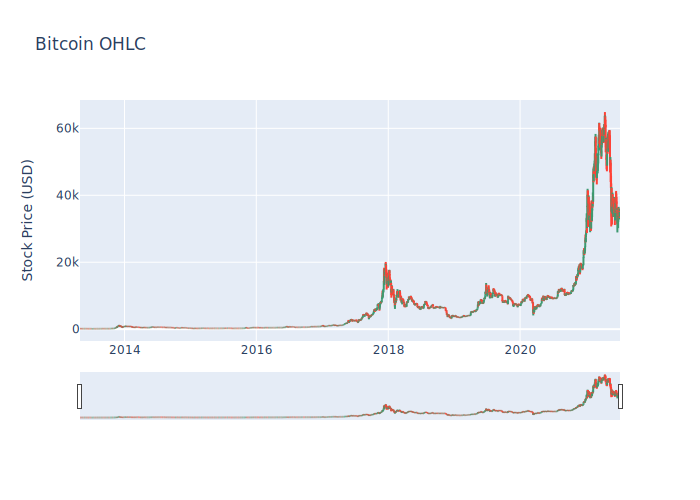

In [10]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'BTC']['Date'],
                             open=df[df.Symbol == 'BTC']['Open'],
                             high=df[df.Symbol == 'BTC']['High'],
                             low=df[df.Symbol == 'BTC']['Low'],
                             close=df[df.Symbol == 'BTC']['Close']))
fig.update_layout(title='Bitcoin OHLC', yaxis_title='Stock Price (USD)')
fig.show(renderer="svg")

/home/julio/.local/share/virtualenvs/crypto-deep-learning-wXDHGxS_/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.

/home/julio/.local/share/virtualenvs/crypto-deep-learning-wXDHGxS_/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/home/julio/.local/share/virtualenvs/crypto-deep-learning-wXDHGxS_/lib/python3.8/site-packages/scipy/integrat

,sumsquare_error,aic,bic,kl_div
lognorm,7.335089e-08,2549.060243,-73050.230270,inf
chi2,1.612113e-07,2467.757915,-70694.933723,inf
gamma,1.638723e-07,2458.288904,-70645.965737,inf
exponpow,2.056986e-07,2377.975011,-69966.038889,inf
powerlaw,2.123075e-07,2344.438160,-69871.452424,inf


/home/julio/.local/share/virtualenvs/crypto-deep-learning-wXDHGxS_/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



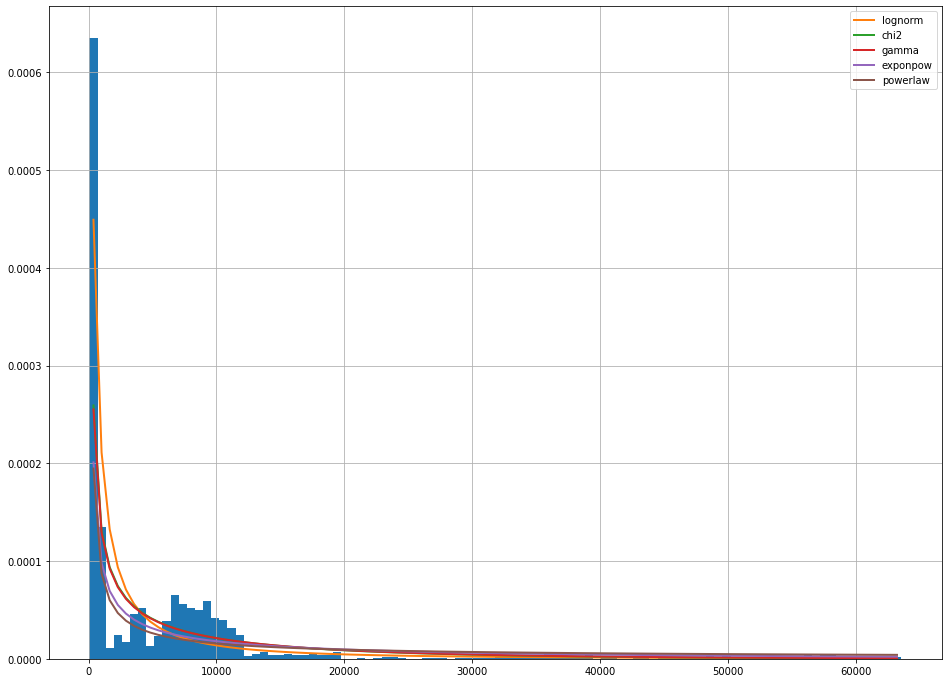

In [61]:
f = Fitter(df[df.Symbol == 'BTC']['Close'], distributions='common')
f.fit()
f.summary()

## Cardano

In [11]:
print(
    f"Min Date: {df[df.Symbol == 'ADA'].Date.min()}, Max Date: {df[df.Symbol == 'ADA'].Date.max()}"
)


Min Date: 2017-10-02 23:59:59, Max Date: 2021-07-06 23:59:59


In [12]:
df[df.Symbol == 'ADA'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,1374.000000,1374.000000,1374.000000,1374.000000,1374.000000,1.374000e+03,1.374000e+03
mean,687.500000,0.269807,0.239710,0.255287,0.256313,8.934183e+08,7.603454e+09
std,396.783946,0.433523,0.380928,0.408456,0.409691,2.107653e+09,1.303878e+10
min,1.000000,0.021050,0.017620,0.018414,0.018539,1.739460e+06,4.806646e+08
25%,344.250000,0.047565,0.044601,0.045898,0.045947,5.014830e+07,1.191263e+09
50%,687.500000,0.090274,0.083164,0.086867,0.087002,1.186742e+08,2.270889e+09
75%,1030.750000,0.194519,0.172442,0.181374,0.183379,4.875977e+08,5.174547e+09
max,1374.000000,2.461766,2.013285,2.300190,2.309113,1.914198e+10,7.377224e+10


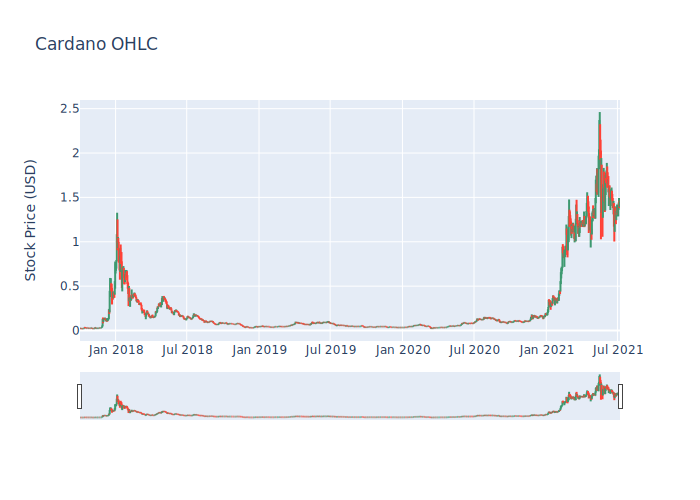

In [13]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'ADA']['Date'],
                             open=df[df.Symbol == 'ADA']['Open'],
                             high=df[df.Symbol == 'ADA']['High'],
                             low=df[df.Symbol == 'ADA']['Low'],
                             close=df[df.Symbol == 'ADA']['Close']))
fig.update_layout(title='Cardano OHLC', yaxis_title='Stock Price (USD)')
fig.show(renderer="svg")

,sumsquare_error,aic,bic,kl_div
lognorm,13.379915,545.794000,-6342.316094,inf
cauchy,22.881790,775.735353,-5612.271511,inf
gamma,38.018179,539.481666,-4907.434561,inf
chi2,38.770461,527.026253,-4880.512121,inf
exponpow,45.139714,482.834157,-4671.521519,inf


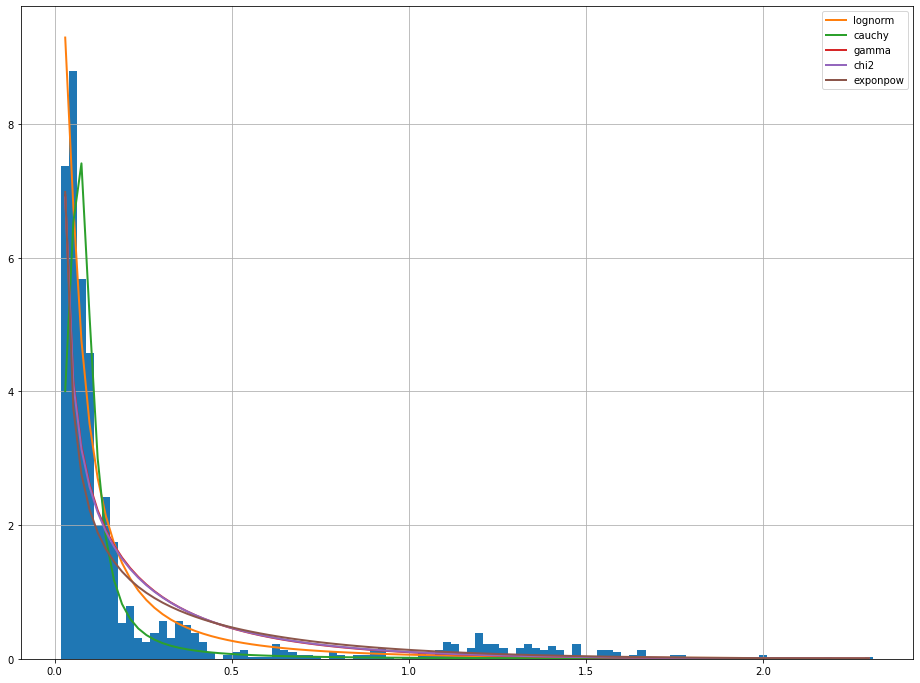

In [60]:
f = Fitter(df[df.Symbol == 'ADA']['Close'], distributions='common')
f.fit()
f.summary()

## Ethereum

In [14]:
print(
    f"Min Date: {df[df.Symbol == 'ETH'].Date.min()}, Max Date: {df[df.Symbol == 'ETH'].Date.max()}"
)


Min Date: 2015-08-08 23:59:59, Max Date: 2021-07-06 23:59:59


In [15]:
df[df.Symbol == 'ETH'].describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,2160.000000,2160.000000,2160.000000,2160.000000,2160.000000,2.160000e+03,2.160000e+03
mean,1080.500000,398.258568,365.592589,382.879899,383.910691,7.057058e+09,4.172084e+10
std,623.682612,628.082281,566.611523,599.719862,601.078766,1.064526e+10,6.909184e+10
min,1.000000,0.482988,0.420897,0.431589,0.434829,1.021280e+05,3.221363e+07
25%,540.750000,14.265225,13.190950,13.757600,13.819200,3.825102e+07,1.135576e+09
50%,1080.500000,205.124631,193.302715,198.425096,198.643691,2.148880e+09,2.070063e+10
75%,1620.250000,396.494561,375.146804,386.264935,386.435272,9.629136e+09,4.231010e+10
max,2160.000000,4362.350542,3785.848603,4174.635873,4168.701049,8.448291e+10,4.828819e+11


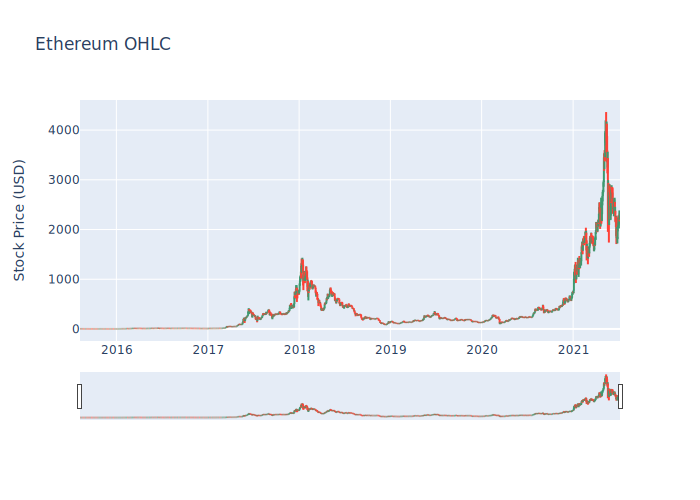

In [16]:
fig = go.Figure(data=go.Ohlc(x=df[df.Symbol == 'ETH']['Date'],
                             open=df[df.Symbol == 'ETH']['Open'],
                             high=df[df.Symbol == 'ETH']['High'],
                             low=df[df.Symbol == 'ETH']['Low'],
                             close=df[df.Symbol == 'ETH']['Close']))
fig.update_layout(title='Ethereum OHLC', yaxis_title='Stock Price (USD)')
fig.show(renderer="svg")

/home/julio/.local/share/virtualenvs/crypto-deep-learning-wXDHGxS_/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning:

The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.

/home/julio/.local/share/virtualenvs/crypto-deep-learning-wXDHGxS_/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning:

The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.

/home/julio/.local/share/virtualenvs/crypto-deep-learning-wXDHGxS_/lib/python3.8/site-packages/scipy/integrat

,sumsquare_error,aic,bic,kl_div
lognorm,0.000012,1990.562564,-40993.872246,inf
chi2,0.000015,1926.338862,-40601.506569,inf
gamma,0.000015,1910.774108,-40529.979286,inf
exponpow,0.000018,1852.457498,-40125.280654,inf
powerlaw,0.000022,1794.694929,-39741.257283,inf


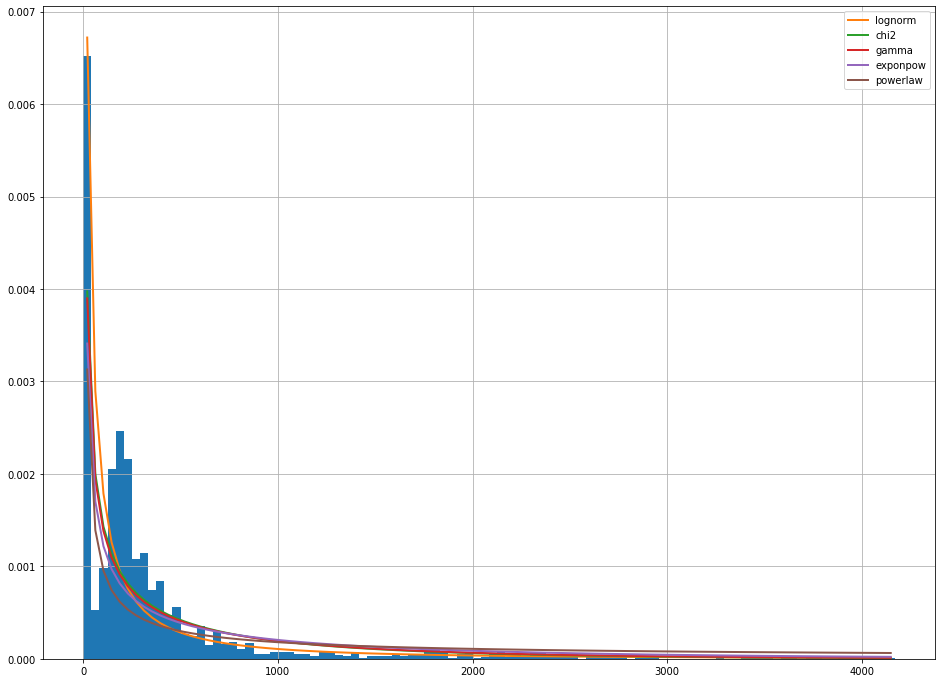

In [62]:
f = Fitter(df[df.Symbol == 'ETH']['Close'], distributions='common')
f.fit()
f.summary()

### Seasonality




<built-in method title of str object at 0x7fdde1c7e8b0>


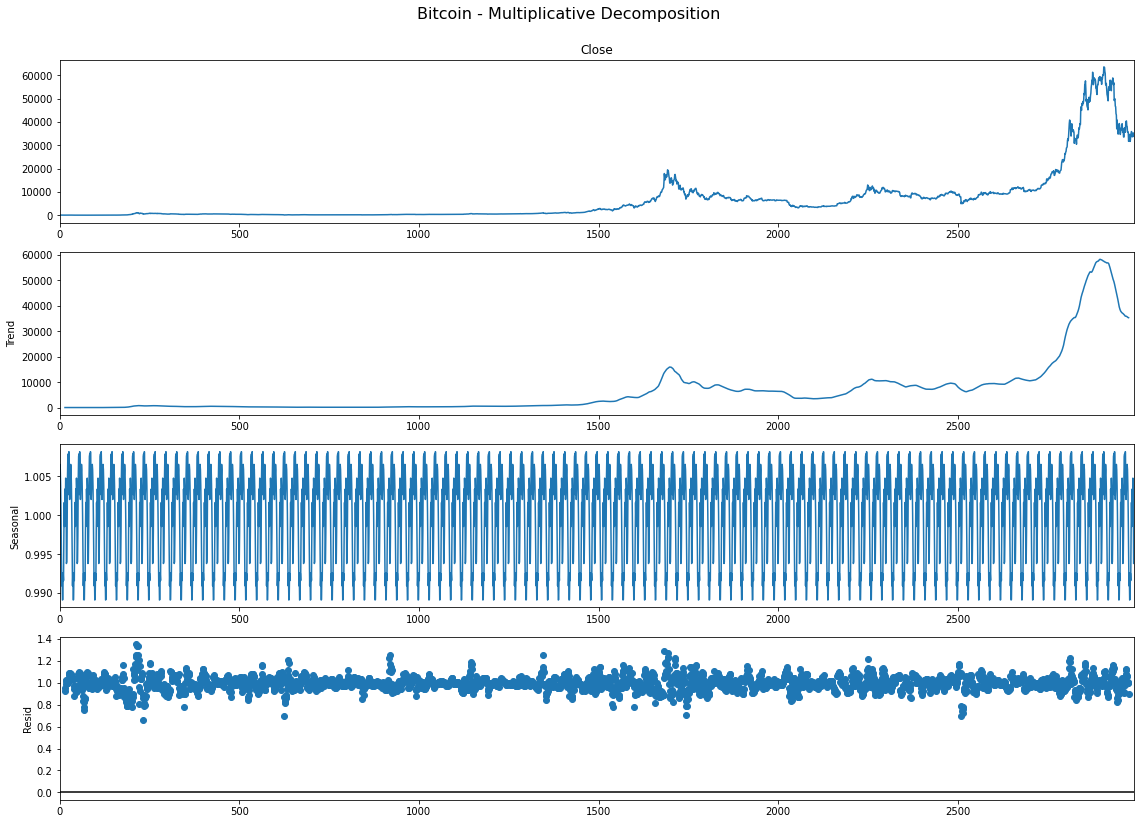

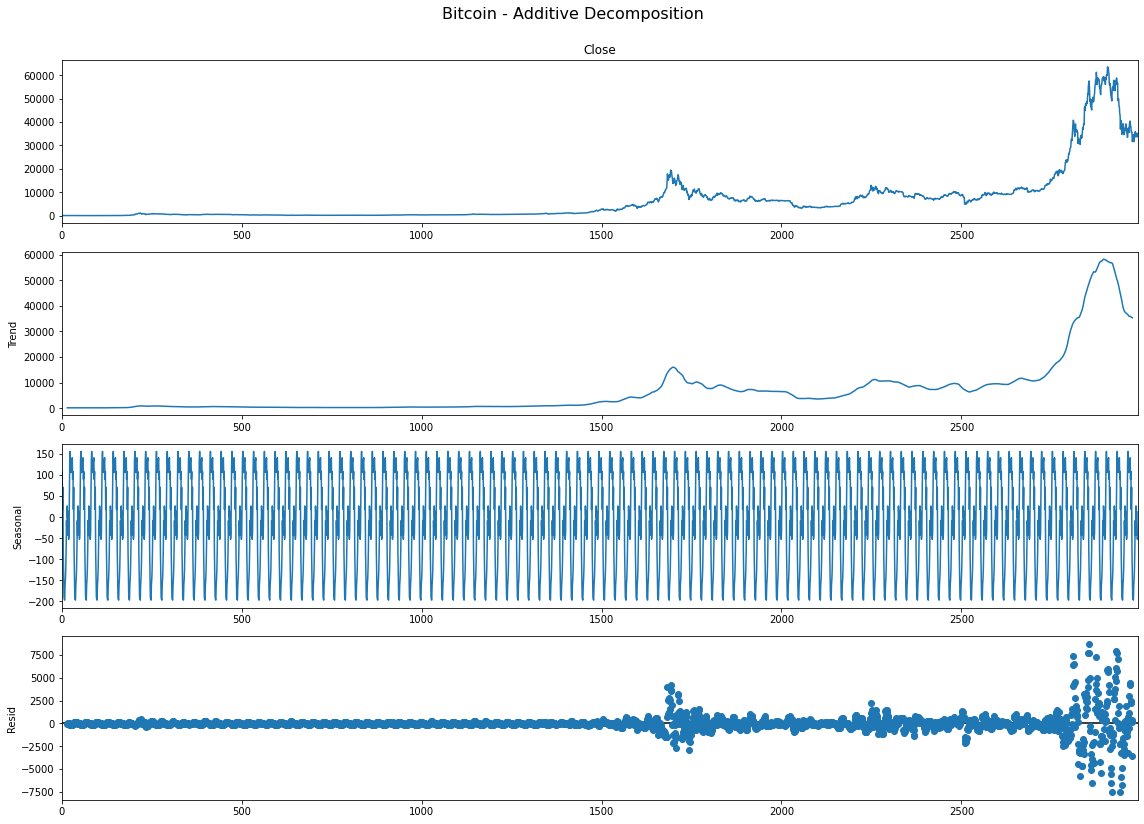




<built-in method title of str object at 0x7fdde79f55f0>


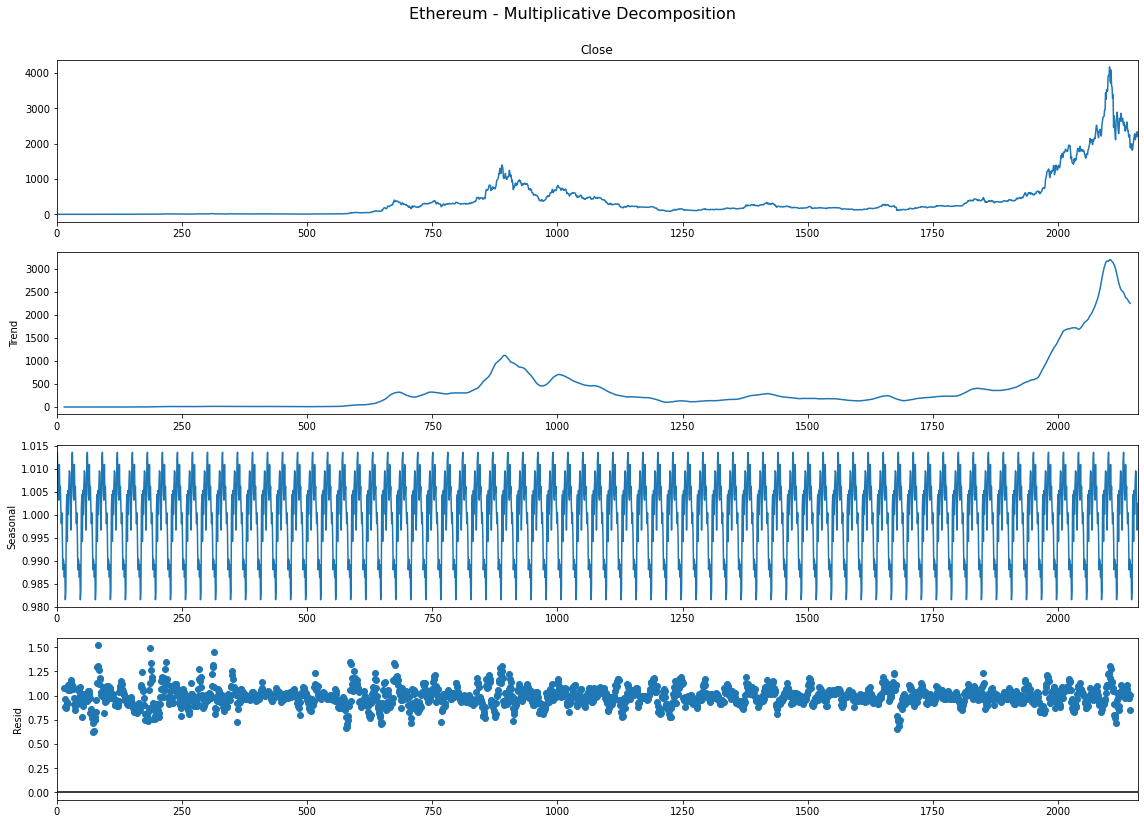

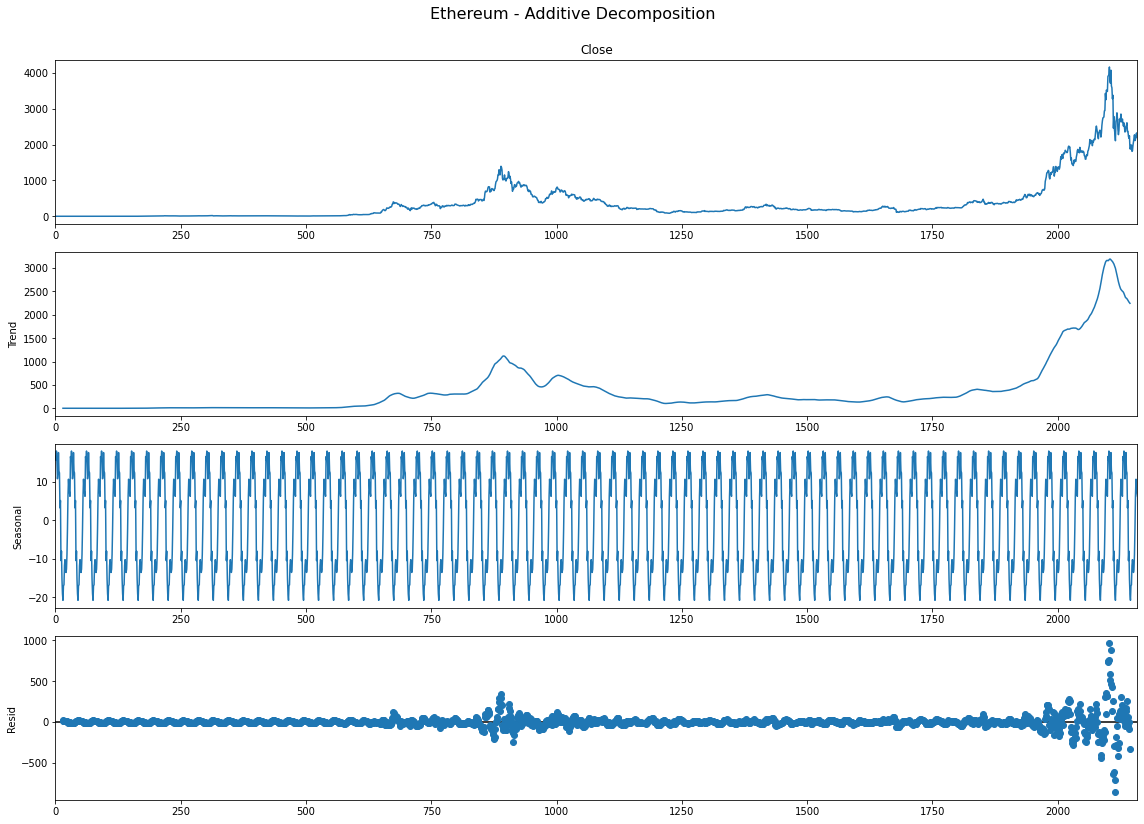




<built-in method title of str object at 0x7fdde79f5870>


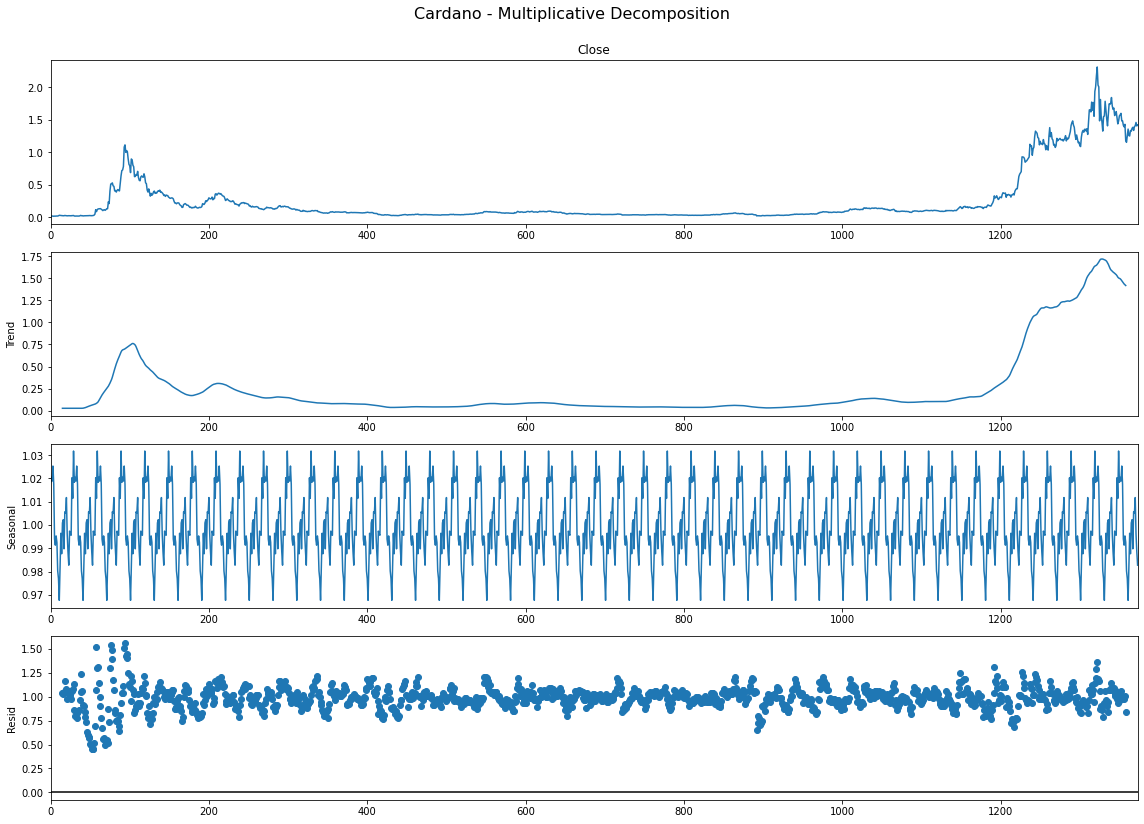

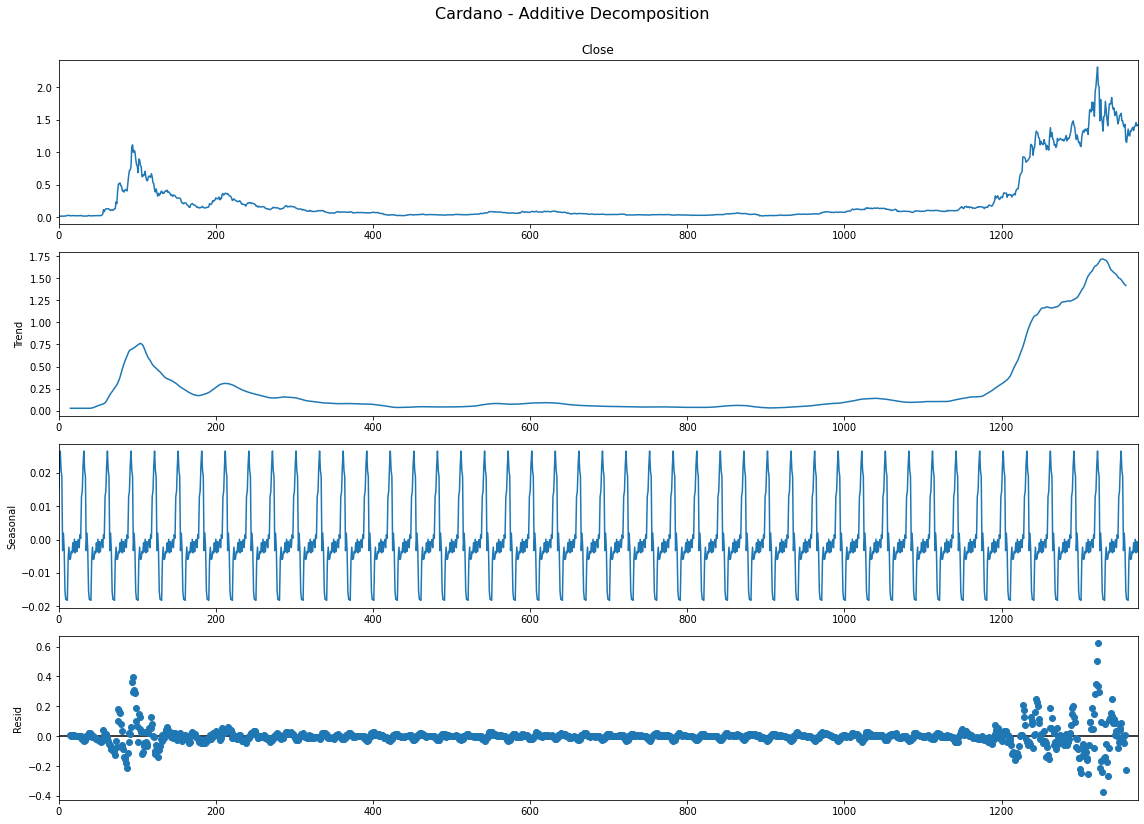

In [17]:
def plot_decompose(df: pd.DataFrame, coin: str, col):
    multiplicative_decomposition = seasonal_decompose(df[col],
                                                      model='multiplicative',
                                                      period=30)

    additive_decomposition = seasonal_decompose(df[col],
                                                model='additive',
                                                period=30)

    plt.rcParams.update({'figure.figsize': (16, 12)})
    multiplicative_decomposition.plot().suptitle(
        f'{coin.title()} - Multiplicative Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    additive_decomposition.plot().suptitle(
        f'{coin.title()} - Additive Decomposition', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


for col in coins:
    print(f'\n\n\n{col.title}')
    plot_decompose(df[df.Name == col.title()], col, 'Close')


## Train Test Split

In order to train our model we need all the information from the 3 coins grouped by date of occurrence. We have created a script to generate this dataset(src/data/make_dataset.py). The script will output the processed dataset into /data/processed/dataset.csv.

In [20]:
processed_df = pd.read_csv('../data/processed/dataset.csv',
                           parse_dates=['date'])
processed_df.head()

,date,bitcoin_sno,bitcoin_high,bitcoin_low,bitcoin_open,bitcoin_close,bitcoin_volume,bitcoin_marketcap,ethereum_sno,ethereum_high,...,ethereum_close,ethereum_volume,ethereum_marketcap,cardano_sno,cardano_high,cardano_low,cardano_open,cardano_close,cardano_volume,cardano_marketcap
0,2013-04-29 23:59:59,1,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-30 23:59:59,2,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-05-01 23:59:59,3,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-05-02 23:59:59,4,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-03 23:59:59,5,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we are using information from the 3 coins, we need to select only the period of time with information for all 3 criptocurrencies. The newest coin is Cardano with stock price information since '2017-10-02'. Therefore, we define this date as the minimum date for our project.

For a fair evaluation of the models performance, we select a holdout dataset using a out of time strategy starting on '2021-04-01'. The final result of train and test dataset are:

* TRAIN: 2017-10-02 to 2021-04-01
* TEST: 2021-04-01 to 2021-07-06

In [21]:
MIN_DATE = '2017-10-02'
TRAIN_TEST_THRESHOLD = '2021-04-01'
train = processed_df[(processed_df.date < TRAIN_TEST_THRESHOLD)
                     & (processed_df.date >= MIN_DATE)]
test = processed_df[(processed_df.date >= TRAIN_TEST_THRESHOLD)
                    & (processed_df.date >= MIN_DATE)]
print(
    f'Train: {train.shape}, Test: {test.shape}, Proportion: {train.shape[0] / (train.shape[0] + test.shape[0]):.2%}'
)

Train: (1277, 22), Test: (97, 22), Proportion: 92.94%


In [22]:
train.isna().sum()

date                  0
bitcoin_sno           0
bitcoin_high          0
bitcoin_low           0
bitcoin_open          0
bitcoin_close         0
bitcoin_volume        0
bitcoin_marketcap     0
ethereum_sno          0
ethereum_high         0
ethereum_low          0
ethereum_open         0
ethereum_close        0
ethereum_volume       0
ethereum_marketcap    0
cardano_sno           0
cardano_high          0
cardano_low           0
cardano_open          0
cardano_close         0
cardano_volume        0
cardano_marketcap     0
dtype: int64

## Feature Engineering

### Columns Selection

In [1]:
class ColumnDropTransformer():
    """ Sklearn Pipeline transformer for dropping columns from a dataframe """

    def __init__(self, columns):
        self.columns = columns

    def transform(self, X, y=None):
        return X.drop(self.columns, axis=1)

    def fit(self, X, y=None):
        return self


Selecting cols that should be used for normalization and cols to drop.

In [24]:
normalize_cols = []
for coin in coins:
    for col in ['open', 'high', 'low', 'close', 'volume', 'marketcap']:
        normalize_cols.append(f'{coin}_{col}')

drop_cols = []
for coin in coins:
    for col in ['sno']:
        drop_cols.append(f'{coin}_{col}')
drop_cols.append('date')

For better reproductibily we create a Sklear Pipeline with the data transformation steps.

In [25]:
minmax_transformer = Pipeline(steps=[('minmax', MinMaxScaler())])

pipeline = Pipeline([
    ("column_dropper", ColumnDropTransformer(drop_cols)),
    ('normalization',
     ColumnTransformer(remainder='passthrough',
                       transformers=[('norm', minmax_transformer,
                                      normalize_cols)],
                       verbose_feature_names_out=True))
])

In [26]:
X_train = pipeline.fit_transform(train)
X_test = pipeline.transform(test)

In [27]:
feature_names = list(pipeline["normalization"].get_feature_names_out())

### Coins Correlation

Now that we have all the coin prices normalized we can plot the price of all coins together.

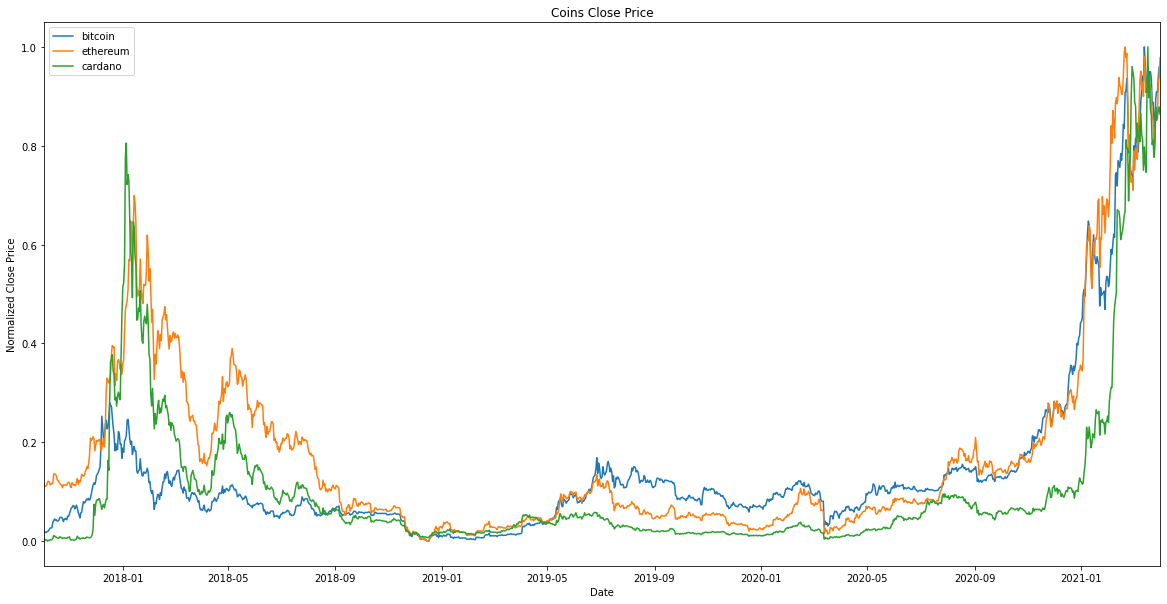

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))

for coin in coins:
    ax.plot(train["date"],
            X_train[:, feature_names.index(f'norm__{coin}_close')],
            label=coin)
ax.set(xlabel="Date",
       ylabel="Normalized Close Price",
       title="Coins Close Price",
       xlim=[min(train["date"]), max(train["date"])])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

### Correlation test

Looking into the correlation plot we can notice the Etheureum close price has the highest correlation with the other coins open price. Therefore we decided to predict the ethereum close price.

Moreover, we can identify multicolinearity between the open price features. Therefore we can discard the application of methods with no multicolinearity assumption, such as Linear Regression.

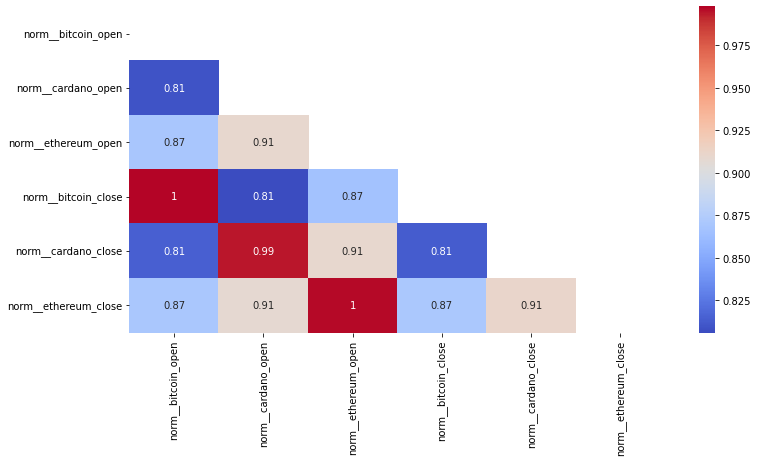

In [30]:
corr_cols = [
    'norm__bitcoin_open', 'norm__cardano_open', 'norm__ethereum_open',
    'norm__bitcoin_close', 'norm__cardano_close', 'norm__ethereum_close'
]
corr_cols_index = [feature_names.index(col) for col in corr_cols]
corr_dataframe = pd.DataFrame(X_train[:, corr_cols_index],
                              columns=corr_cols,
                              dtype=np.float64)
mask = np.triu(corr_dataframe.corr())
plt.figure(figsize=(12,6))
sns.heatmap(corr_dataframe.corr(),
            mask=mask,
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm',
            annot=True)
plt.show()

### Stationary Test

We ran Augmented Dickey Fuller test to check for stationary on all open and close price. In the report belowe, we can notice that all the p-value are high, making the assumption for the data being the generated from a stationary distribution false. Therefore, we can not apply strategies that requires stationary distributions such as ARIMA on this dataset.

In [31]:
response_string = "adf: {0:.4f}, p-value: {1:.4f}, usedlag: {2}, nobs: {3}, critical_values: {4}"

results_cols = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical values']

for col in corr_cols:
    col_index = feature_names.index(col)
    adf_results = adfuller(X_train[:, col_index])
    print(f"\n---------\n{col}\n{response_string.format(*adf_results)}")


---------
norm__bitcoin_open
adf: 3.8634, p-value: 1.0000, usedlag: 20, nobs: 1256, critical_values: {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}

---------
norm__cardano_open
adf: -1.1591, p-value: 0.6909, usedlag: 22, nobs: 1254, critical_values: {'1%': -3.4355754676859886, '5%': -2.8638475772391665, '10%': -2.5679985805677017}

---------
norm__ethereum_open
adf: 0.6970, p-value: 0.9898, usedlag: 22, nobs: 1254, critical_values: {'1%': -3.4355754676859886, '5%': -2.8638475772391665, '10%': -2.5679985805677017}

---------
norm__bitcoin_close
adf: 3.8429, p-value: 1.0000, usedlag: 20, nobs: 1256, critical_values: {'1%': -3.4355671297788666, '5%': -2.8638438984080117, '10%': -2.5679966213893057}

---------
norm__cardano_close
adf: -0.9426, p-value: 0.7736, usedlag: 23, nobs: 1253, critical_values: {'1%': -3.4355796466416777, '5%': -2.863849421064024, '10%': -2.5679995625056926}

---------
norm__ethereum_close
adf: 1.0059, p-value: 0.9943, usedlag: 

### Modeling

***Dependant Variables:***
* bitcoin_open
* cardano_open
* ethereum_open

***Target Variable***
* ethereum_close

In [32]:
model_cols = [
    'norm__bitcoin_open', 'norm__cardano_open', 'norm__ethereum_open'
]
model_cols_id = [feature_names.index(col) for col in model_cols]
y_train = X_train[:, feature_names.index('norm__ethereum_close')]
X_train = X_train[:, model_cols_id]
y_test = X_test[:, feature_names.index('norm__ethereum_close')]
X_test = X_test[:, model_cols_id]

In [33]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """ Evaluate regression model performance on test dataset"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"Model: {str(model)} MSE: {mse:.2f}, RMSE: {rmse:.2f}, r2_score: {r2:.2f}")
    return mse, rmse, r2

As we identified above the dataset does not meet the assumptions for Linear Regression models. Therefore, we tested non-linear strategies such as GammaGAM, RandomForestRegressor and GradientBoostingRegressor.

In [76]:
models = [
    GammaGAM(),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42),
]
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

Model: LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False) MSE: 0.07, RMSE: 0.27, r2_score: 0.16
Model: GammaGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False) MSE: 0.06, RMSE: 0.25, r2_score: 0.29
Model: RandomForestRegressor(random_state=42) MSE: 0.22, RMSE: 0.47, r2_score: -1.50
Model: GradientBoostingRegressor(random_state=42) MSE: 0.23, RMSE: 0.48, r2_score: -1.63


Comparing the RMSE values for the holdout dataset we can see that the best results was obtained by the GammaGAM estimator. However, the model had a poor performance when comparing with a very conservative estimator like predicting no change between the open and close price. 

In [93]:
class DummyOpenPrice:
    """ Dummy classifier that will always predict the close price to be the same as the open price """
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        """ Return the ethereum open price for each row in X. """
        return X[:, 2]
    
    def __repr__(self):
        return "Dummy Ethereum Open Price"

class_models = [DummyRegressor(), DummyRegressor(strategy='median'), DummyOpenPrice()]
for model in class_models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

Model: DummyRegressor() MSE: 1.41, RMSE: 1.19, r2_score: -14.99
Model: DummyRegressor(strategy='median') MSE: 1.61, RMSE: 1.27, r2_score: -17.23
Model: Dummy Ethereum Open Price MSE: 0.01, RMSE: 0.10, r2_score: 0.88


### GAM

Even tough the GAM predicitons are not better than our Dummy estimator, lets evaluate if it able to learn the prices trend and how are the holdout prediction in a plot compared with the observed data.

In [99]:
gam = GammaGAM()
gam.fit(X_train, y_train)

GammaGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + s(2) + intercept, 
   tol=0.0001, verbose=False)

<Figure size 1152x864 with 0 Axes>

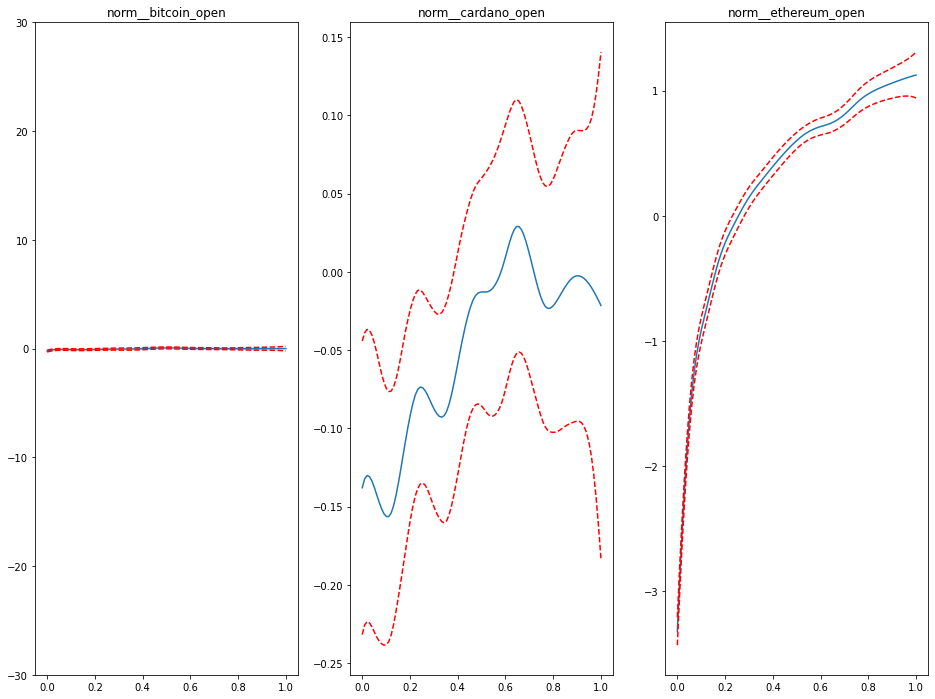

In [100]:
plt.figure()
fig, axs = plt.subplots(1,3)

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(model_cols[i])

In [101]:
gam_predictions_train = gam.predict(X_train)
gam_predictions_test = gam.predict(X_test)
dummy_predictions_train = DummyOpenPrice().fit(X_train).predict(X_train)
dummy_predictions_test = DummyOpenPrice().fit(X_train).predict(X_test)

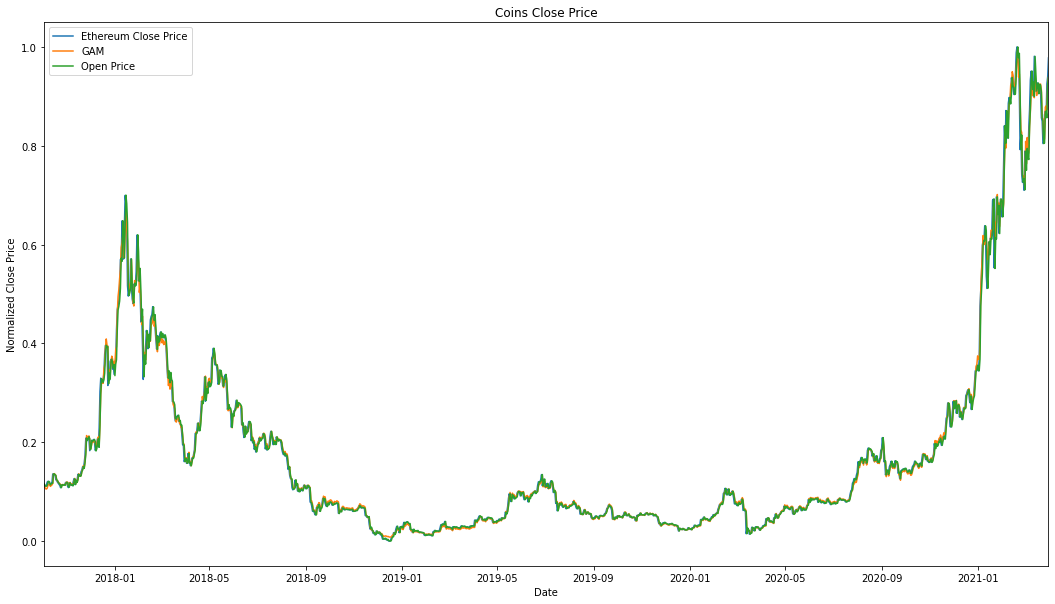

In [102]:
fig, ax = plt.subplots(figsize=(18, 10))

ax.plot(train["date"], y_train, label="Ethereum Close Price")
ax.plot(train["date"], gam_predictions_train, label="GAM")
ax.plot(train["date"], dummy_predictions_train, label="Open Price")
ax.set(xlabel="Date",
       ylabel="Normalized Close Price",
       title="Coins Close Price",
       xlim=[min(train["date"]), max(train["date"])])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

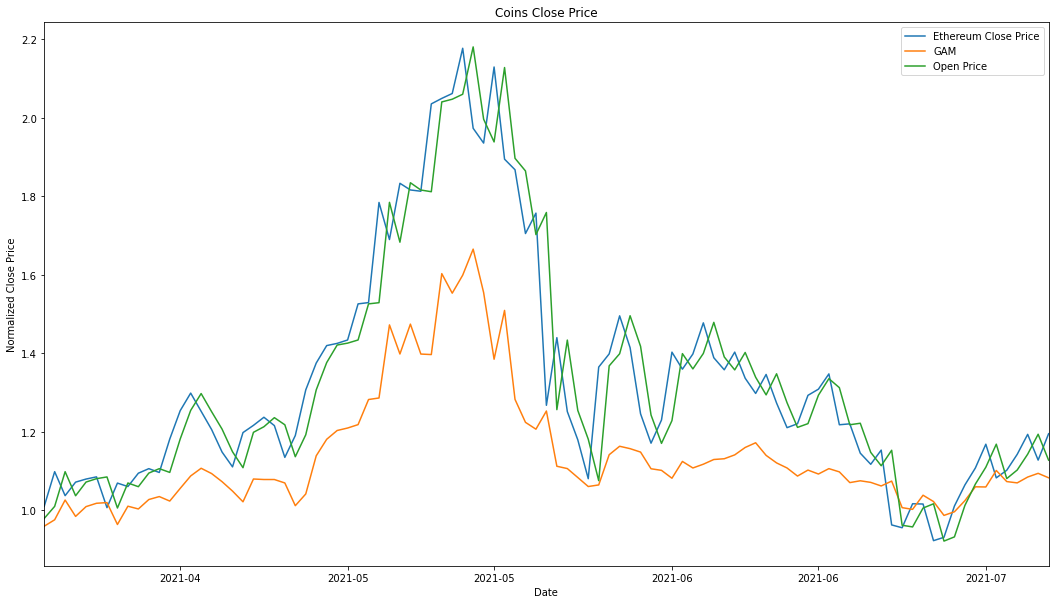

In [103]:
fig, ax = plt.subplots(figsize=(18, 10))

ax.plot(test["date"], y_test, label="Ethereum Close Price")
ax.plot(test["date"], gam_predictions_test, label="GAM")
ax.plot(test["date"], dummy_predictions_test, label="Open Price")
ax.set(xlabel="Date",
       ylabel="Normalized Close Price",
       title="Coins Close Price",
       xlim=[min(test["date"]), max(test["date"])])
ax.legend(loc='best')

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.show()

## Trend Prediciton (Classification)

In [83]:
y_train_trend = [
    train["ethereum_close"].iloc[i] > train["ethereum_open"].iloc[i]
    for i in range(train.shape[0])
]
y_test_trend = [
    test["ethereum_close"].iloc[i] > test["ethereum_open"].iloc[i]
    for i in range(test.shape[0])
]


In [84]:
def evaluate_class_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print(
        f"Model: {str(model)} Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, Accuracy: {accuracy:.2f}"
    )


In [106]:
class GammaGAMTrend(GammaGAM):

    def predict(self, X):
        """ Compare the GAM prediction with the open price to determine if the price is going up or down. """
        predicted  = self.predict_mu(X)
        return np.array([1 if X[i,2] > predicted[i] else 0 for i in range(X.shape[0])])
    
    def __repr__(self):
        return "GammaGAMTrend"

In [107]:
class_models = [
    LogisticGAM(),
    GammaGAMTrend(),
    RandomForestClassifier(random_state=42),
    GradientBoostingClassifier(random_state=42)
]
for model in class_models:
    evaluate_class_model(model, X_train, y_train_trend, X_test, y_test_trend)

Model: LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + intercept, tol=0.0001, verbose=False) Precision: 0.80, Recall: 0.07, F1: 0.13, Accuracy: 0.44
Model: GammaGAMTrend Precision: 0.59, Recall: 0.96, F1: 0.73, Accuracy: 0.58
Model: RandomForestClassifier(random_state=42) Precision: 0.50, Recall: 0.04, F1: 0.07, Accuracy: 0.41
Model: GradientBoostingClassifier(random_state=42) Precision: 1.00, Recall: 0.04, F1: 0.07, Accuracy: 0.43


In [108]:
class_models = [DummyClassifier(), DummyClassifier(strategy='uniform')]
for model in class_models:
    evaluate_class_model(model, X_train, y_train_trend, X_test, y_test_trend)

Model: DummyClassifier() Precision: 0.59, Recall: 1.00, F1: 0.74, Accuracy: 0.59
Model: DummyClassifier(strategy='uniform') Precision: 0.46, Recall: 0.32, F1: 0.37, Accuracy: 0.38


In [109]:
gam_predictions_test_trend = GammaGAMTrend().fit(X_train,y_train).predict(X_test)

In [110]:
confusion_matrix(y_test_trend, gam_predictions_test_trend)

array([[ 2, 38],
       [ 5, 52]])